# TSC2 Kepler Demo

In [1]:
import numpy as np
np.random.seed = 1212
import pandas as pd
import matplotlib.pyplot as plt
import loaders
import data
from extern import features
from extern.quarterTools import data_scaler
from extern import kinship

%matplotlib inline

## TESS Data for Kepler targets in Sector 14

In [2]:
kepler_ref   = pd.read_csv('./data/kepler_lookup.csv')
kepler_ref   = kepler_ref.set_index("TIC_ID")


In [3]:
# csv for demo, pickle for science
# 1 file is too big for github...
kf1 = pd.read_csv('./data/kepler_feats_1.csv').set_index("TIC_ID")
kf2 = pd.read_csv('./data/kepler_feats_2.csv').set_index("TIC_ID")
kf3 = pd.read_csv('./data/kepler_feats_3.csv').set_index("TIC_ID")

kepler_feats = kf1.append(kf2)
kepler_feats = kepler_feats.append(kf3)

scaled_feats = data_scaler(kepler_feats)

## Scoring (optional) - NOTE: There will be some variation in top outliers, not all light curve files are available in the data folder included (top 800 should be consistent, no guarantees)

In [4]:
min_neighbor  = 1
max_neighbor  = None  # optional - generates additional scores to different neighbors and an average score from all
sample_size   = int(1e3)  # optional: score to a random subset of data points
kepler_scores = kinship.kinship_scores(scaled_feats, kmin=min_neighbor, kmax = max_neighbor, samp_size=sample_size)

kepler_scores_df           = pd.DataFrame(data=kepler_scores.T)
kepler_scores_df["TIC_ID"] = scaled_feats.index
kepler_scores_df["rank"]   = kepler_scores_df.rank(ascending=False).loc[:,0]
kictic       = pd.read_csv('./data/kic2tic.csv')

kepler_scores_df = kepler_scores_df.sort_values(by="rank").set_index("TIC_ID").rename({"0":"score"}, axis=1) # rearranging for utility
kepler_scores_df["KIC_ID"] = kictic.set_index("TIC").loc[kepler_scores_df.index.values, 'KIC']


### Import scores file

In [5]:
kepler_scores_df = pd.read_csv('./data/kepler_scores.csv').set_index('TIC_ID')

## Look at the top outliers (top 1k lightcurves in data/lcs)

In [6]:
data_dir = "./data/lcs/"

topout_ref = kepler_ref.loc[kepler_scores_df.index[:1000]]
sec = topout_ref.Sector.values
cam = topout_ref.Camera.values
files = data_dir+topout_ref.Filename.values

In [7]:
lcc = loaders.LightCurveCollection(sec, cam, files) # loads the lightcurves in with the masks we used for analysis
lcc.load_all_lcs() # this will take a moment

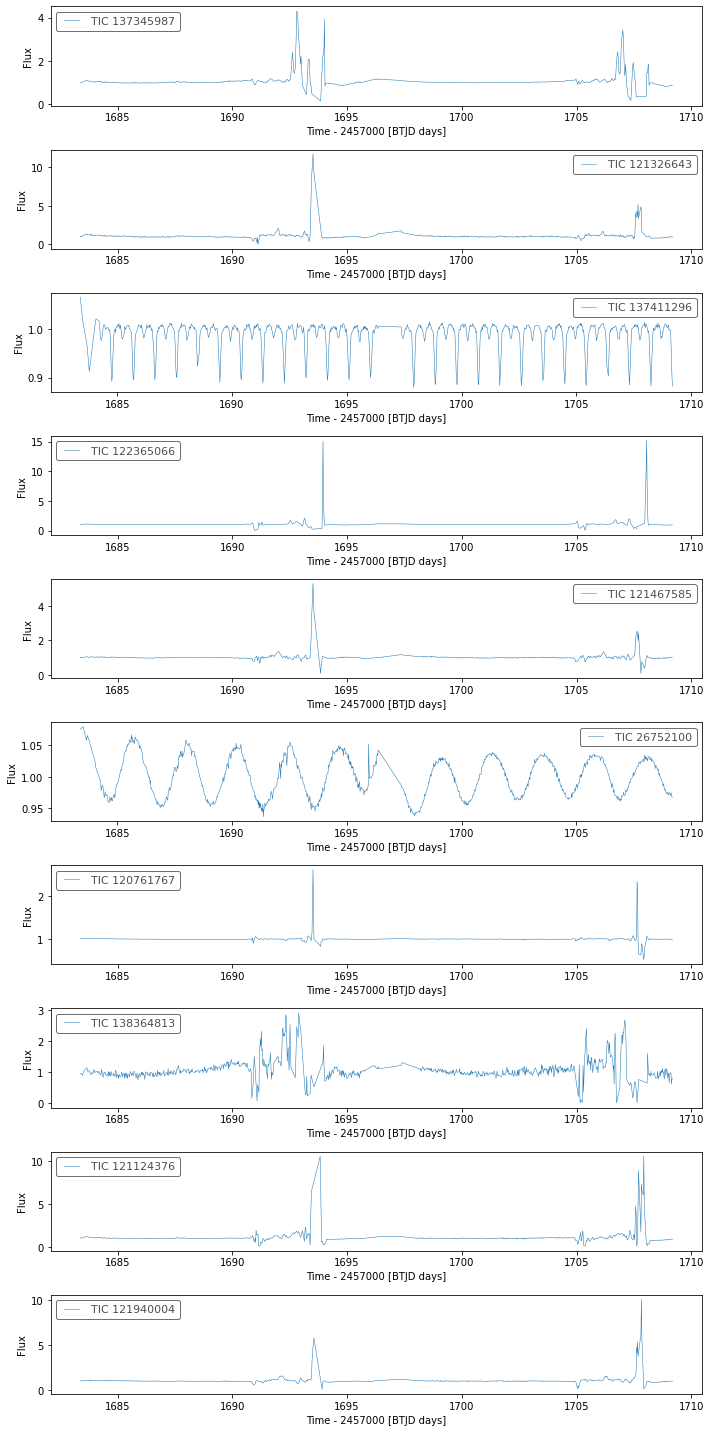

In [8]:
plot_lcs = lcc.lcs[500:510] # play with these numbers to look at different outliers
nplots = len(plot_lcs)
fig, ax = plt.subplots(nplots, figsize=(10, 2*nplots), tight_layout=True)
for i, lc in enumerate(plot_lcs):
    lc.plot(ax=ax[i])

### Kepler Summary Table from Giles & Walkowicz 2020 - Includes information about outlier scoring over all quarters and SIMBAD metadata.

In [9]:
kic_summary = pd.read_csv("./data/KIC_Summary.csv")
kic_summary = kic_summary.set_index("KIC")

topout_summary = kic_summary.loc[kepler_scores_df.KIC_ID.values[:1000]] # have to use scores_df bc it has KICs
topout_summary['TIC'] = topout_ref.index[:1000]

In [10]:
topout_summary.iloc[500:510]

,median_rank,most_outlying_rank,most_outlying_quarter,OTYPE,RA,DEC,BIBLIO,TIC
KIC,,,,,,,,
1434792,137682.0,60434.0,Q3,Star,19 27 46.3421,+37 00 25.276,2015ApJ...809....8B,137345987
3838075,60219.0,37948.0,Q8,RGB*,19 10 21.6358,+38 55 18.380,2018A&A...616A..94V|2018AJ....156...18P|2018Ap...,121326643
5621299,50293.0,30327.0,Q17,Star,19 28 52.9199,+40 53 08.424,2016A&A...594A..39F|2016ApJ...822...86M,137411296
2436680,43563.5,35726.0,Q10,NaN,NaN,NaN,NaN,122365066
4045261,112200.0,109059.0,Q2,NaN,NaN,NaN,NaN,121467585
11246246,2723.0,1878.0,Q5,Eruptive*,19 31 40.0215,+48 57 44.334,2016A&A...594A..39F|2016ApJ...829...23D|2015Ap...,26752100
1701672,82625.0,53986.0,Q16,RotV*,19 04 50.3953,+37 16 48.458,2019AJ....158...58C|2015A&A...583A..65R|2015Ap...,120761767
3351787,43689.0,7496.0,Q4,RotV*,19 35 22.7164,+38 25 09.929,2015A&A...583A..65R|2015ApJ...809....8B|2014Ap...,138364813
3429856,33928.0,22215.0,Q15,RotV*,19 08 57.3421,+38 33 45.207,2015A&A...583A..65R|2015ApJ...809....8B|2014Ap...,121124376


#### The third plot looks like an EB, but SIMBAD says star. The pixel level data shows us that it looks a bit crowded, the EB behavior is probably from the background star.

In [17]:
import lightkurve as lk

In [18]:
tpf = lk.search_tesscut("TIC 137411296")[0].download(cutout_size=(15,15))

<AxesSubplot:title={'center':'Target ID: TIC 137411296, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

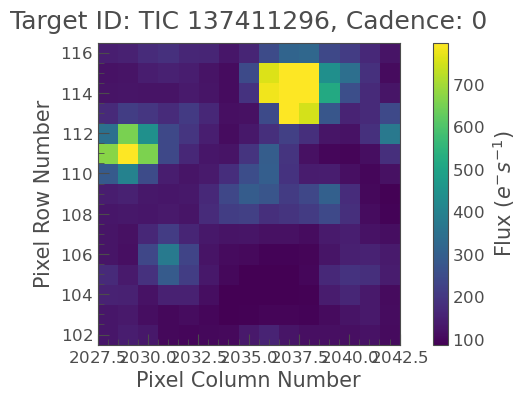

In [19]:
tpf.plot()